# **CIS 5450 Final Project - NBA Game Outcome Prediction**
*Vidushi Gupta, Jeffrey Oduman, Darian Parks*

# Part 1: Introduction

For our final project, our goal was to better understand the main game statistics that determine the outcome of an NBA game between two given teams. To do this, we chose a dataset, game_df, which contains the away and home teams' id/names, win/loss result, field goals scored, assists, rebounds, and other game statistics for each game.

We utilized the rolling average to capture each team's recent performance at any given point. Specifically, for every game in the dataset, we calculated a 5-game rolling average for each key statistic separately for the home and away teams. This allowed us to prevent data leakage and avoid using the statistics from a game itself to predict its outcome. We ensured that all input features reflected only past data available at prediction time, which makes our model very applicable to the real world.

Utilizing this technique, we were able to understand which types of statistics are most relevant in determining the outcome of a game. Our methodology, outcomes, and analysis are provided below. We have done our best to justify and explain each finding, visualization, and the "so what" question. We hope you find our project useful and we look forward to presenting it.

# Part 2: Notebook Setup

We began by importing pandas, numpy, and other libraries we explored in class. We import model-specific libraries prior to each model.

In [ ]:
# Initial imports
import pandas as pd
import numpy as np
import seaborn as sns
from string import ascii_letters
import matplotlib.pyplot as plt
import datetime as dt
import requests
from lxml import html
import math
import re
import json
import os
import plotly.express as px
import plotly.graph_objects as go

In [ ]:
%%capture
!apt update
!pip install kaggle
!pip install optuna
!pip install scikit-optimize

## 2.1 Loading Game Data

### 2.1.1 Loading Data From Kaggle

In [ ]:
# mount to drive
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# Create the kaggle directory and
# (NOTE: Do NOT run this cell more than once unless restarting kernel)
!mkdir ~/.kaggle

In [ ]:
# Read the uploaded kaggle.json file
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/

cp: cannot stat '/content/drive/MyDrive/kaggle.json': No such file or directory


In [ ]:
# Download dataset (DO NOT CHANGE)
!!kaggle datasets download -d wyattowalsh/basketball

['Traceback (most recent call last):',
 '  File "/usr/local/bin/kaggle", line 10, in <module>',
 '    sys.exit(main())',
 '             ^^^^^^',
 '  File "/usr/local/lib/python3.11/dist-packages/kaggle/cli.py", line 68, in main',
 '    out = args.func(**command_args)',
 '          ^^^^^^^^^^^^^^^^^^^^^^^^^',
 '  File "/usr/local/lib/python3.11/dist-packages/kaggle/api/kaggle_api_extended.py", line 1734, in dataset_download_cli',
 '    with self.build_kaggle_client() as kaggle:',
 '         ^^^^^^^^^^^^^^^^^^^^^^^^^^',
 '  File "/usr/local/lib/python3.11/dist-packages/kaggle/api/kaggle_api_extended.py", line 688, in build_kaggle_client',
 "    username=self.config_values['username'],",
 '             ~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^',
 "KeyError: 'username'"]

In [ ]:
# Unzip folder in Colab content folder
!unzip -q basketball.zip -d basketball_data

unzip:  cannot find or open basketball.zip, basketball.zip.zip or basketball.zip.ZIP.


### 2.1.2 Storing Dataframe

In [ ]:
# read game.csv
# game_df = pd.read_csv('/content/basketball_data/csv/game.csv')
game_df = pd.read_csv('game.csv')

# Part 3: Exploratory Data Analysis and Preprocessing

## Part 3.1: Initial Modifications

### Part 3.1.1: Viewing the Dataframe

In [ ]:
# Printing the head to see the initial structure
game_df.head(5)

,season_id,team_id_home,team_abbreviation_home,team_name_home,game_id,game_date,matchup_home,wl_home,min,fgm_home,...,reb_away,ast_away,stl_away,blk_away,tov_away,pf_away,pts_away,plus_minus_away,video_available_away,season_type
0,21946,1610610035,HUS,Toronto Huskies,24600001,1946-11-01 00:00:00,HUS vs. NYK,L,0,25.0,...,NaN,NaN,NaN,NaN,NaN,NaN,68.0,2.0,0.0,Regular Season
1,21946,1610610034,BOM,St. Louis Bombers,24600003,1946-11-02 00:00:00,BOM vs. PIT,W,0,20.0,...,NaN,NaN,NaN,NaN,NaN,25.0,51.0,-5.0,0.0,Regular Season
2,21946,1610610032,PRO,Providence Steamrollers,24600002,1946-11-02 00:00:00,PRO vs. BOS,W,0,21.0,...,NaN,NaN,NaN,NaN,NaN,NaN,53.0,-6.0,0.0,Regular Season
3,21946,1610610025,CHS,Chicago Stags,24600004,1946-11-02 00:00:00,CHS vs. NYK,W,0,21.0,...,NaN,NaN,NaN,NaN,NaN,22.0,47.0,-16.0,0.0,Regular Season
4,21946,1610610028,DEF,Detroit Falcons,24600005,1946-11-02 00:00:00,DEF vs. WAS,L,0,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,50.0,17.0,0.0,Regular Season


In [ ]:
# View columns and types
game_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23791 entries, 0 to 23790
Data columns (total 55 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   season_id               23791 non-null  int64  
 1   team_id_home            23791 non-null  int64  
 2   team_abbreviation_home  23791 non-null  object 
 3   team_name_home          23791 non-null  object 
 4   game_id                 23791 non-null  int64  
 5   game_date               23791 non-null  object 
 6   matchup_home            23791 non-null  object 
 7   wl_home                 23791 non-null  object 
 8   min                     23791 non-null  int64  
 9   fgm_home                23778 non-null  float64
 10  fga_home                8344 non-null   float64
 11  fg_pct_home             8301 non-null   float64
 12  fg3m_home               10573 non-null  float64
 13  fg3a_home               5108 non-null   float64
 14  fg3_pct_home            4760 non-null 

### Part 3.1.2: Storing Columns

In [ ]:
# Splitting home and away columns in case we need to analyze teams individually
home_cols = [col for col in game_df.columns if not col.endswith('away') ]
away_cols = [col for col in game_df.columns if not col.endswith('home')]
home_cols, away_cols

(['season_id',
  'team_id_home',
  'team_abbreviation_home',
  'team_name_home',
  'game_id',
  'game_date',
  'matchup_home',
  'wl_home',
  'min',
  'fgm_home',
  'fga_home',
  'fg_pct_home',
  'fg3m_home',
  'fg3a_home',
  'fg3_pct_home',
  'ftm_home',
  'fta_home',
  'ft_pct_home',
  'oreb_home',
  'dreb_home',
  'reb_home',
  'ast_home',
  'stl_home',
  'blk_home',
  'tov_home',
  'pf_home',
  'pts_home',
  'plus_minus_home',
  'video_available_home',
  'season_type'],
 ['season_id',
  'game_id',
  'game_date',
  'min',
  'team_id_away',
  'team_abbreviation_away',
  'team_name_away',
  'matchup_away',
  'wl_away',
  'fgm_away',
  'fga_away',
  'fg_pct_away',
  'fg3m_away',
  'fg3a_away',
  'fg3_pct_away',
  'ftm_away',
  'fta_away',
  'ft_pct_away',
  'oreb_away',
  'dreb_away',
  'reb_away',
  'ast_away',
  'stl_away',
  'blk_away',
  'tov_away',
  'pf_away',
  'pts_away',
  'plus_minus_away',
  'video_available_away',
  'season_type'])

In [ ]:
# Storing numerical features
numerical_features = [
    col for col in game_df.columns
    if np.issubdtype(game_df[col].dtype, np.number)
]
numerical_features

['season_id',
 'team_id_home',
 'game_id',
 'min',
 'fgm_home',
 'fga_home',
 'fg_pct_home',
 'fg3m_home',
 'fg3a_home',
 'fg3_pct_home',
 'ftm_home',
 'fta_home',
 'ft_pct_home',
 'oreb_home',
 'dreb_home',
 'reb_home',
 'ast_home',
 'stl_home',
 'blk_home',
 'tov_home',
 'pf_home',
 'pts_home',
 'plus_minus_home',
 'video_available_home',
 'team_id_away',
 'fgm_away',
 'fga_away',
 'fg_pct_away',
 'fg3m_away',
 'fg3a_away',
 'fg3_pct_away',
 'ftm_away',
 'fta_away',
 'ft_pct_away',
 'oreb_away',
 'dreb_away',
 'reb_away',
 'ast_away',
 'stl_away',
 'blk_away',
 'tov_away',
 'pf_away',
 'pts_away',
 'plus_minus_away',
 'video_available_away']

## Part 3.2: Missing Data Analysis

Null analysis is crucial because missing data can bias model training, reduce accuracy, or lead to invalid conclusions if not handled properly. Our visualization clearly highlights which columns suffer the most from missing values, allowing us to make informed decisions about imputation or removal.

In [ ]:
# Columns with some missing/null data and the percentage null
missing_data = game_df.isnull().mean().sort_values(ascending=False) * 100
missing_data = missing_data[missing_data > 0]


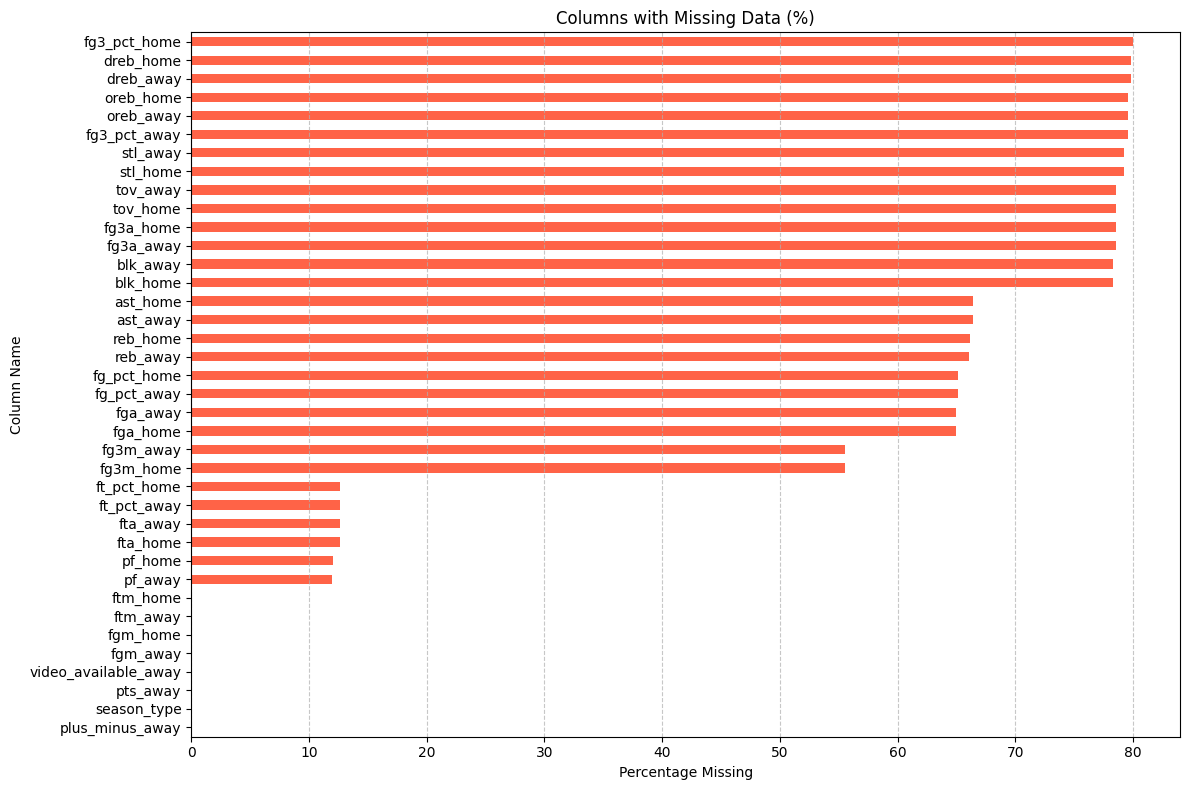

In [ ]:
# Visualizing percentage null by column
plt.figure(figsize=(12, 8))
missing_data.sort_values().plot(kind='barh', color='tomato')
plt.title('Columns with Missing Data (%)')
plt.xlabel('Percentage Missing')
plt.ylabel('Column Name')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

**Analysis**

This plot highlights which columns contain missing data, with many key stats like fg3_pct_home, dreb_home, and stl_away missing in a large portion of the dataset. Identifying these gaps early was important so we could either impute or drop them to avoid model bias or failure. Visualizing the null values helped us prioritize which features to clean first.

## Part 3.3: Calculating Top Potential Targets

We analyzed which numerical features are the most affected by other features to see dependencies. This might show us features that have linear relationships.

In [ ]:
# Potential top 10 targets based on correlation with other columns
numeric_df = game_df[numerical_features]

corr_matrix = numeric_df.corr().abs()

In [ ]:
# Calculating the mean correlation with all other columns
mean_corr_with_others = corr_matrix.apply(lambda col: col.drop(col.name).mean())

best_target_candidates = mean_corr_with_others.sort_values(ascending=False)

top_targets = best_target_candidates.head(10)

<ipython-input-18-85f4c67457ce>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_targets.values, y=top_targets.index, palette='coolwarm')


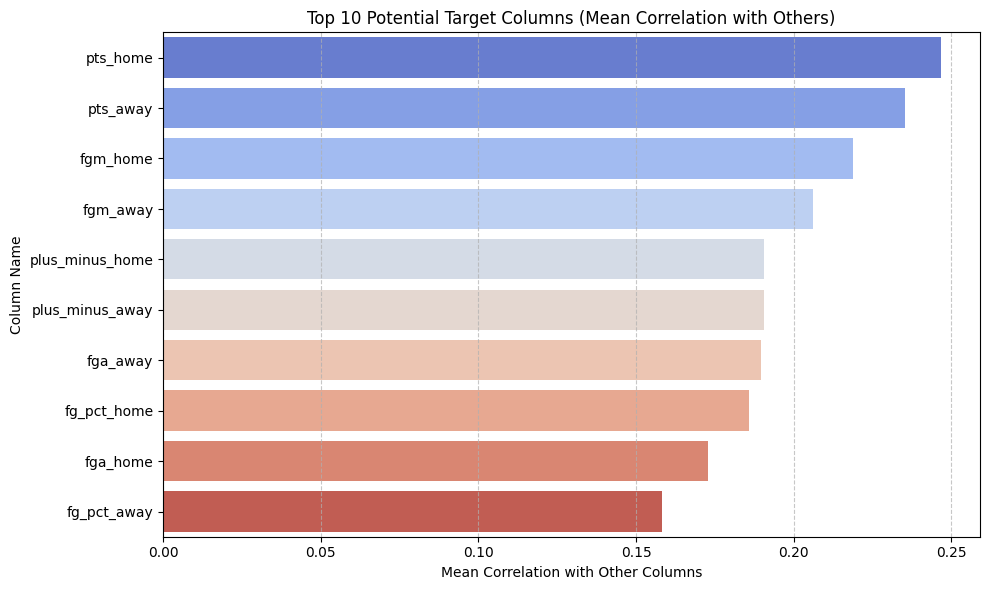

In [ ]:
# Visualization for correlation between variables
plt.figure(figsize=(10, 6))
sns.barplot(x=top_targets.values, y=top_targets.index, palette='coolwarm')
plt.title('Top 10 Potential Target Columns (Mean Correlation with Others)')
plt.xlabel('Mean Correlation with Other Columns')
plt.ylabel('Column Name')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

**Analysis**

Stats like pts_home and pts_away show the strongest correlations, indicating they are influenced by many other variables and may serve well as predictive targets. However, these directly indicate which team won so we consider removing these from our model.

## Part 3.4 Analyzing Defensive Strategies

To explore how NBA teams' defensive strategies have evolved, we analyzed changes in points per game across different decades. An increase in average points suggests a shift toward stronger offensive play and, by contrast, potentially weaker defensive emphasis. We used a line chart to capture these trends over time and clearly illustrate long-term shifts.

In [ ]:
# Converting 'game_date' column to datetime
game_df['year'] = pd.to_datetime(game_df['game_date']).dt.year
game_df['decade'] = (game_df['year'] // 10) * 10


In [ ]:
# Calculate average offensive points by decade by taking mean of home and away
off_def_trend = game_df.groupby('decade')[['pts_home', 'pts_away']].mean()
off_def_trend['avg_pts'] = off_def_trend['pts_home'] + off_def_trend['pts_away']

<Axes: title={'center': 'Average Points per Game by Decade'}, xlabel='decade'>

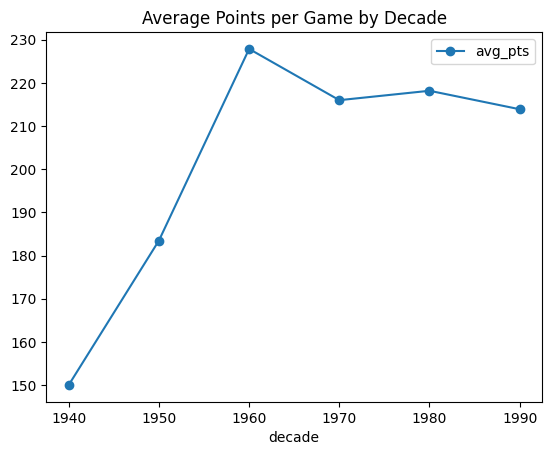

In [ ]:
# Plot the total average points per game over time to visualize scoring trends
off_def_trend.plot(y='avg_pts', kind='line', marker='o', title='Average Points per Game by Decade')

**Analysis**

 There was a steep decrease from 1960 to 2000 in average points scored per game, suggesting that teams may prioritiz defensive strategies. However, the trend has reversed in recent decades, with points rising again. This suggests that we see a high inlfuence of rebounds in game wins.

## Part 3.5 Three-pointer Analysis

Another important metric for understanding offensive vs. defensive trends is tracking where players are making shots from over time. For example, an increase in three-point attempts and makes may reflect a modern shift toward perimeter-focused offense. A line graph was used to capture how these shot patterns evolve across seasons.

Using **Plotly** for visualizing the trend in shot type attempts over decades is justified due to its **interactivity**, **clarity**, and **customizability**. This makes it ideal for exploring long-term trends in sports analytics. This interactive format helps reveal subtle changes in 2-point, 3-point, and free throw attempts that might otherwise go unnoticed.

In [ ]:
import plotly.graph_objects as go

# Ensure date and decade columns are clean and present
game_df['game_date'] = pd.to_datetime(game_df['game_date'], errors='coerce')
game_df['year'] = game_df['game_date'].dt.year
game_df['decade'] = (game_df['year'] // 10) * 10

# Calculate total attempts per game type
game_df['total_fg3a'] = game_df['fg3a_home'] + game_df['fg3a_away']
game_df['total_fga'] = game_df['fga_home'] + game_df['fga_away']
game_df['total_fta'] = game_df['fta_home'] + game_df['fta_away']
game_df['total_fg2a'] = game_df['total_fga'] - game_df['total_fg3a']

# Average shot attempts by decade
shot_distribution = game_df.groupby('decade')[['total_fg2a', 'total_fg3a', 'total_fta']].mean()

# Build interactive line chart with Plotly
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=shot_distribution.index,
    y=shot_distribution['total_fg2a'],
    mode='lines+markers',
    name='2PT Attempts',
    line=dict(color='#1f77b4', width=3),
    marker=dict(size=8)
))

fig.add_trace(go.Scatter(
    x=shot_distribution.index,
    y=shot_distribution['total_fg3a'],
    mode='lines+markers',
    name='3PT Attempts',
    line=dict(color='#d62728', width=3),
    marker=dict(size=8)
))

fig.add_trace(go.Scatter(
    x=shot_distribution.index,
    y=shot_distribution['total_fta'],
    mode='lines+markers',
    name='Free Throw Attempts',
    line=dict(color='#2ca02c', width=3),
    marker=dict(size=8)
))

# Update layout with title, axes, legend, and styling
fig.update_layout(
    title='Average Shot Type Attempts per Game by Decade',
    xaxis_title='Decade',
    yaxis_title='Average Attempts per Game',
    legend_title='Shot Type',
    template='plotly_white',
    height=600,
    xaxis=dict(tickmode='linear', tick0=shot_distribution.index.min(), dtick=10),
    yaxis=dict(showgrid=True, gridcolor='lightgray')
)

fig.show()


**Analysis**

This visualization shows a clear shift in offensive strategy over time, with 2-point attempts steadily declining and 3-point attempts rising significantly since the 1980s. Free throw attempts have also declined slightly, suggesting fewer fouls or changes in play style. Thus, we may see increased influence of 3-pointers.

## Part 3.6: Analysis of Features Contributing to Winning

We analyzed which numerical features are most likely to influence winning outcomes to better understand what separates high-performing teams from others. We used a heat map to visually emphasize the relative strength of each feature’s importance through color variation.

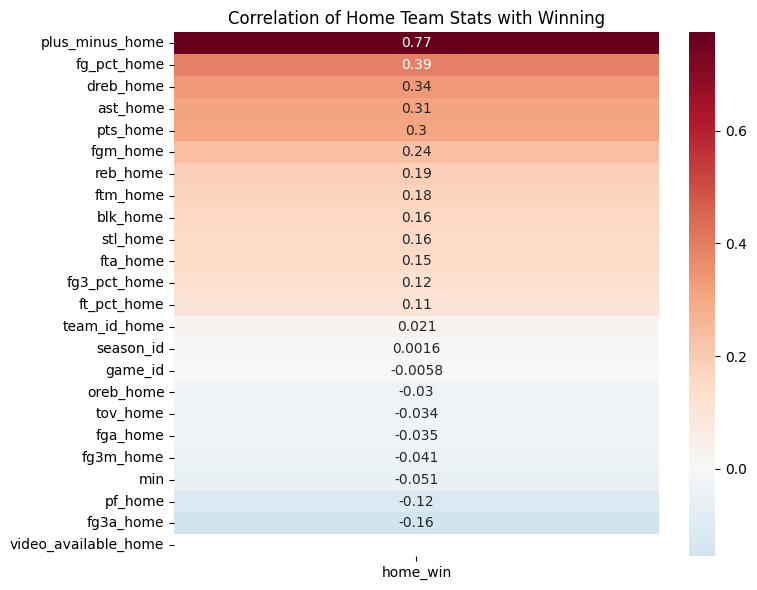

In [ ]:
#Correlation Heatmap Between Stats and Win Probability
game_df['home_win'] = game_df['pts_home'] > game_df['pts_away']

# Computing correlation between stats and win (focusing on home team for now)
home_stats = game_df[[x for x in home_cols if x in numerical_features] + ['home_win']]
home_corr = home_stats.corr()
sorted_corr = home_corr['home_win'].drop('home_win').sort_values(ascending=False)
sorted_corr_df = sorted_corr.to_frame()

plt.figure(figsize=(8, 6))
sns.heatmap(sorted_corr_df, annot=True, cmap='RdBu_r', center=0)
plt.title('Correlation of Home Team Stats with Winning')
plt.tight_layout()
plt.show()

**Analysis**

This heatmap shows how strongly various home team statistics correlate with winning. The strongest predictor is plus_minus_home, which makes sense as it directly reflects scoring margin. We will likely remove this from our model as it directly tells us who won.

## Part 3.7: Analysis Possessive vs Offensive Efficiency
We analysed whether more possession implied more offensive efficiency (e.g. more points scored). A "possession" is a sequence where one team controls the ball until they either score, turn the ball over, or miss and the other team gets the rebound. More possessions usually mean more scoring opportunities, so it's crucial to normalize performance stats by possessions (e.g., points per possession).

**Explanation of the approximation:**
possessions ≈ FGA + 0.44 * FTA + TOV
This formula estimates possessions based on the key events that end a possession:

FGA (Field Goal Attempts): Attempting a shot usually ends a possession unless an offensive rebound occurs. Still, it's a good indicator of a full period of possession.

0.44 * FTA (Free Throw Attempts): Not every free throw results in a change of possession.

The factor 0.44 is an empirical constant -- accounts for one-shot fouls, two-shot fouls, and "and-1" situations. Some free throws don’t use up a full possession (e.g., technical fouls, continuation fouls).

TOV (Turnovers): It clearly ends the possession, so counted fully.

In [ ]:
# Estimate possessions using simplified formula
game_df['possessions'] = (
    game_df['fga_home'] + game_df['fga_away'] +
    0.44 * (game_df['fta_home'] + game_df['fta_away']) +
    game_df['tov_home'] + game_df['tov_away']
)

# Total points scored in the game
game_df['total_points'] = game_df['pts_home'] + game_df['pts_away']

# Offensive efficiency: points per 100 possessions
game_df['off_efficiency'] = (game_df['total_points'] / game_df['possessions']) * 100

# Create interactive scatterplot with Plotly Express
fig = px.scatter(
    game_df,
    x='possessions',
    y='off_efficiency',
    color='decade',
    title='Possession vs. Offensive Efficiency',
    labels={
        'possessions': 'Estimated Possessions per Game',
        'off_efficiency': 'Points per 100 Possessions',
        'decade': 'Decade'
    },
    opacity=0.6,
    color_continuous_scale='viridis' if game_df['decade'].dtype != 'object' else None,
    template='plotly_white',
    height=600
)

# Add grid lines and update layout
fig.update_layout(
    xaxis=dict(showgrid=True, gridcolor='lightgray'),
    yaxis=dict(showgrid=True, gridcolor='lightgray'),
    legend_title_text='Decade'
)

fig.show()


**Analysis**

There is no significant relationship between possessions and the rate of points scored per possession.

## Part 3.8: Analysis of Offensive vs. Defensive Strength By Decade

We analyzed how teams' offensive and defensive strengths have evolved over time by plotting average points scored versus points allowed per game. The top-left quadrant (low points scored, high points allowed) reflects weaker performance, while the bottom-right quadrant (high points scored, low points allowed) represents stronger teams.

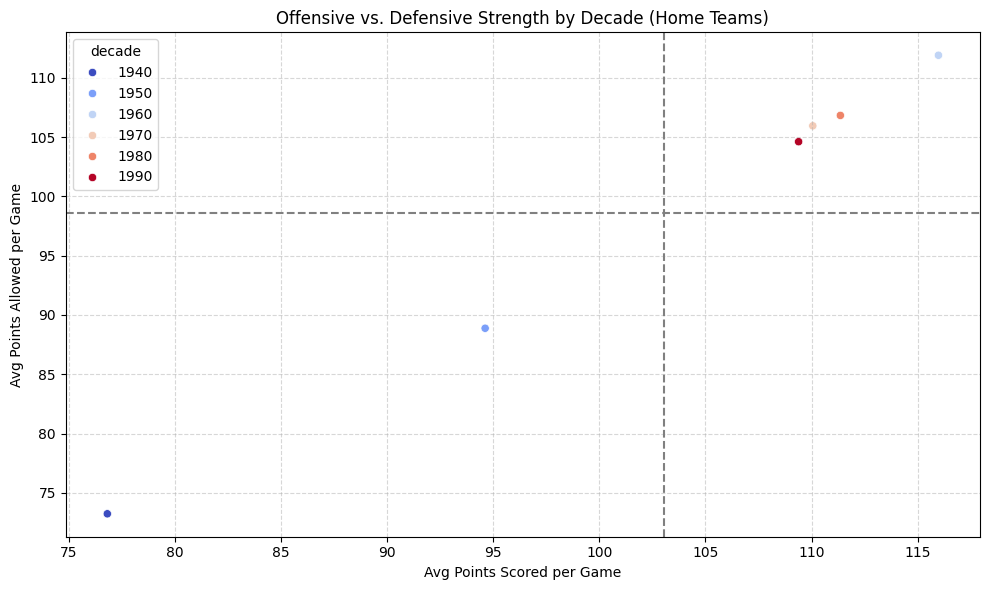

In [ ]:
# Pooling seasons by defensive and offensive strength

game_df['points_scored'] = game_df['pts_home']
game_df['points_allowed'] = game_df['pts_away']
home_df = game_df[['decade', 'points_scored', 'points_allowed']].dropna()

yearly_avg = home_df.groupby('decade')[['points_scored', 'points_allowed']].mean()

plt.figure(figsize=(10, 6))
sns.scatterplot(data=yearly_avg, x='points_scored', y='points_allowed', palette='coolwarm', hue=yearly_avg.index)

plt.axhline(yearly_avg['points_allowed'].mean(), color='gray', linestyle='--')
plt.axvline(yearly_avg['points_scored'].mean(), color='gray', linestyle='--')

plt.title('Offensive vs. Defensive Strength by Decade (Home Teams)')
plt.xlabel('Avg Points Scored per Game')
plt.ylabel('Avg Points Allowed per Game')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


**Analysis**

The scatter plot illustrates how home teams’ offensive and defensive strengths have shifted by decade. We see a clear trend toward higher points scored and allowed, especially in recent decades, indicating a shift toward more offensively oriented gameplay at the cost of defensive intensity.

**Alternate visualisation** of the proportion of scoring types over the decades. Using plotly. We use a stacked bar chart since we are comparing proportions over multiple categories over time. Using Plotly for this scoring breakdown visualization is justified because it offers an interactive and visually compelling way to compare how the contributions of 2-point shots, 3-point shots, and free throws to total game scoring have evolved across different decades. A stacked bar chart effectively communicates the proportional differences in scoring sources, and Plotly enhances this by allowing users to hover over bars for precise values, toggle categories in the legend, and zoom into specific time periods.

In [ ]:
# Compute points from 3s, 2s, and free throws
game_df['pts_fg3'] = 3 * (game_df['fg3m_home'] + game_df['fg3m_away'])
game_df['pts_fg2'] = 2 * ((game_df['fgm_home'] + game_df['fgm_away']) - (game_df['fg3m_home'] + game_df['fg3m_away']))
game_df['pts_ft'] = game_df['ftm_home'] + game_df['ftm_away']

# Group and normalize
score_breakdown = game_df.groupby('decade')[['pts_fg2', 'pts_fg3', 'pts_ft']].mean()
score_pct = score_breakdown.div(score_breakdown.sum(axis=1), axis=0) * 100

# Create Plotly stacked bar chart
fig = go.Figure()

fig.add_trace(go.Bar(
    x=score_pct.index,
    y=score_pct['pts_fg2'],
    name='2PT',
    marker_color='lightblue'
))

fig.add_trace(go.Bar(
    x=score_pct.index,
    y=score_pct['pts_fg3'],
    name='3PT',
    marker_color='salmon'
))

fig.add_trace(go.Bar(
    x=score_pct.index,
    y=score_pct['pts_ft'],
    name='Free Throws',
    marker_color='gold'
))

fig.update_layout(
    barmode='stack',
    title='Scoring Breakdown by Source (Per Game Average by Decade)',
    xaxis_title='Decade',
    yaxis_title='Percentage of Total Points',
    legend_title='Scoring Type',
    template='plotly_white',
    height=500
)

fig.show()

## Part 3.9: Final Processing Using EDA Findings

### Part 3.9.1 Cleaning Dataframe

In [ ]:
#Delete rows used for visualization

game_df.drop(columns=[
    'pts_fg3', 'pts_fg2', 'pts_ft', 'points_scored',
    'points_allowed', 'off_efficiency', 'total_fg3a',
    'total_fga', 'total_fta', 'total_fg2a', 'decade', 'year', 'possessions'
    ], inplace=True)

In [ ]:
# Drop unnecessary columns
game_df_simple = game_df.drop(['matchup_home', 'matchup_away', 'team_abbreviation_home', 'team_abbreviation_away',
              'video_available_home', 'video_available_away', 'min', 'season_id', 'team_id_home', 'team_id_away', 'plus_minus_home', 'plus_minus_away',
                                 'game_id', 'wl_home', 'wl_away', 'pts_away', 'pts_home'], axis=1)

game_df_simple.dropna(inplace=True)
game_df_simple.reset_index(drop=True, inplace=True)

game_df_simple.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4333 entries, 0 to 4332
Data columns (total 40 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   team_name_home  4333 non-null   object        
 1   game_date       4333 non-null   datetime64[ns]
 2   fgm_home        4333 non-null   float64       
 3   fga_home        4333 non-null   float64       
 4   fg_pct_home     4333 non-null   float64       
 5   fg3m_home       4333 non-null   float64       
 6   fg3a_home       4333 non-null   float64       
 7   fg3_pct_home    4333 non-null   float64       
 8   ftm_home        4333 non-null   float64       
 9   fta_home        4333 non-null   float64       
 10  ft_pct_home     4333 non-null   float64       
 11  oreb_home       4333 non-null   float64       
 12  dreb_home       4333 non-null   float64       
 13  reb_home        4333 non-null   float64       
 14  ast_home        4333 non-null   float64       
 15  stl_

## Part 3.9.2: Rolling Average Calculation

We used the idea of a rolling average to keep track of how well teams have been doing in recent years. For each team name (encoded), we calculated the average of their last five games for each game statistic column (e.g., field goal rebounds, etc.).

These were calculated prior to each game and used as inputs to predict the outcome, ensuring that only past performance data was used at prediction time.

In [ ]:
game_df_rolling = game_df_simple.copy()
# Score stat columns
stats = ['fg_pct_home', 'reb_home', 'fgm_home', 'fgm_away', 'ast_home', 'tov_home', 'ft_pct_home',
         'fg_pct_away', 'reb_away', 'ast_away', 'tov_away', 'ft_pct_away', 'dreb_away', 'dreb_home',
         'fg3_pct_home', 'fg3_pct_away', 'ftm_home', 'ftm_away']

# Compute rolling averages for each stat by team
for stat in stats:
    if '_home' in stat:
        team_col = 'team_name_home'
    else:
        team_col = 'team_name_away'

    game_df_rolling[f'{stat}_avg5'] = (
        game_df_rolling
        .groupby(team_col)[stat]
        .shift(1)
        .rolling(window=5)
        .mean()
    )

In [ ]:
# Drop rows where any rolling average feature is NaN (games without 5 prior matches of data)
game_df_rolling = game_df_rolling.dropna(subset=[f"{s}_avg5" for s in stats])

In [ ]:
pd.options.display.max_columns = None
game_df_rolling.head()

,team_name_home,game_date,fgm_home,fga_home,fg_pct_home,fg3m_home,fg3a_home,fg3_pct_home,ftm_home,fta_home,ft_pct_home,oreb_home,dreb_home,reb_home,ast_home,stl_home,blk_home,tov_home,pf_home,team_name_away,fgm_away,fga_away,fg_pct_away,fg3m_away,fg3a_away,fg3_pct_away,ftm_away,fta_away,ft_pct_away,oreb_away,dreb_away,reb_away,ast_away,stl_away,blk_away,tov_away,pf_away,season_type,home_win,total_points,fg_pct_home_avg5,reb_home_avg5,fgm_home_avg5,fgm_away_avg5,ast_home_avg5,tov_home_avg5,ft_pct_home_avg5,fg_pct_away_avg5,reb_away_avg5,ast_away_avg5,tov_away_avg5,ft_pct_away_avg5,dreb_away_avg5,dreb_home_avg5,fg3_pct_home_avg5,fg3_pct_away_avg5,ftm_home_avg5,ftm_away_avg5
31,Los Angeles Lakers,1983-05-31,41.0,92.0,0.446,1.0,3.0,0.333,25.0,31.0,0.806,16.0,27.0,43.0,26.0,7.0,3.0,20.0,31.0,Philadelphia 76ers,42.0,81.0,0.519,0.0,1.0,0.000,31.0,40.0,0.775,13.0,28.0,41.0,29.0,9.0,11.0,17.0,28.0,Playoffs,False,223.0,0.4898,52.2,47.8,42.4,31.0,20.2,0.7126,0.4874,41.2,27.6,14.8,0.7248,26.8,34.8,0.2190,0.0000,17.0,21.2
44,Los Angeles Lakers,1984-06-10,53.0,105.0,0.505,1.0,2.0,0.500,12.0,17.0,0.706,19.0,25.0,44.0,31.0,9.0,3.0,14.0,28.0,Boston Celtics,39.0,84.0,0.464,1.0,3.0,0.333,29.0,35.0,0.829,13.0,28.0,41.0,25.0,7.0,8.0,19.0,24.0,Playoffs,True,227.0,0.4754,51.2,46.4,42.8,25.4,13.8,0.7070,0.4844,41.8,25.2,17.6,0.7478,28.6,31.6,0.0666,0.2372,27.0,19.8
45,Boston Celtics,1984-06-12,34.0,86.0,0.395,0.0,2.0,0.000,43.0,51.0,0.843,20.0,32.0,52.0,18.0,11.0,3.0,14.0,23.0,Los Angeles Lakers,41.0,84.0,0.488,2.0,8.0,0.250,18.0,28.0,0.643,9.0,24.0,33.0,28.0,9.0,8.0,17.0,32.0,Playoffs,True,213.0,0.4916,50.6,47.2,41.8,26.0,14.6,0.7084,0.4734,41.2,24.0,16.4,0.7592,28.2,32.2,0.1866,0.3134,27.2,23.8
46,West NBA All Stars West,1984-01-29,63.0,120.0,0.525,1.0,3.0,0.333,18.0,22.0,0.818,18.0,34.0,52.0,46.0,11.0,6.0,29.0,31.0,East NBA All Stars East,63.0,121.0,0.521,0.0,2.0,0.000,28.0,38.0,0.737,20.0,40.0,60.0,39.0,21.0,4.0,23.0,23.0,All-Star,False,299.0,0.5134,48.6,50.0,44.6,30.4,16.0,0.6818,0.4754,43.2,26.2,17.6,0.7282,28.4,32.0,0.2200,0.2134,24.4,21.8
47,West NBA All Stars West,1984-01-29,63.0,120.0,0.525,1.0,3.0,0.333,18.0,22.0,0.818,18.0,34.0,52.0,46.0,11.0,6.0,29.0,31.0,East NBA All Stars East,63.0,121.0,0.521,0.0,2.0,0.000,28.0,38.0,0.737,20.0,40.0,60.0,39.0,21.0,4.0,23.0,23.0,All Star,False,299.0,0.5122,50.6,52.2,49.4,33.4,19.6,0.7282,0.4890,46.8,29.0,19.4,0.7076,30.8,33.6,0.2866,0.2134,24.6,23.2


# Part 4: Random Forest Model

To predict the relative feature importances, we first decided to utilize the Random Forest Classifier. We needed to do some model specific pre-processing including feature engineering for categorical variables (team_name_away, team_name_home, season_type). We also recalculated the rolling averages for statistics relevant only to this model.

Random Forest feature importance seemed like an interpretable, simple baseline model to that we could utilize to predict influential variables.

## Part 4.1: Model-specific Preprocessing

In this section, we one-hot encoded features we thought would be relevant, converted our target variable column to binary, and dropped columns not relevant to feature importances.

In [ ]:
# Importing necessary packages
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

###4.1.1 Feature Engineering

In this section, we used encoding for categorical variables like 'season type.' We needed this as a feature in our model and thus used the reduced one-hot encoding method.

In [ ]:
# Reduced one-hot encoding for categorical variable 'season type'
categorical_cols = ['season_type']

rf_game_df = pd.get_dummies(game_df_rolling, columns=categorical_cols, drop_first=True)

In [ ]:
# Storing target variable column as integer
rf_game_df['home_win'] = rf_game_df['home_win'].astype(int)

In [ ]:
# Dropping irrelevant columns or columns that
cols_to_drop = [
    'total_points', 'season_type_All-Star', 'season_type_Playoffs', 'season_type_Regular Season'
]
rf_game_df = rf_game_df.drop(columns=cols_to_drop)


In [ ]:
# Check which columns remain
rf_game_df.columns

Index(['team_name_home', 'game_date', 'fgm_home', 'fga_home', 'fg_pct_home',
       'fg3m_home', 'fg3a_home', 'fg3_pct_home', 'ftm_home', 'fta_home',
       'ft_pct_home', 'oreb_home', 'dreb_home', 'reb_home', 'ast_home',
       'stl_home', 'blk_home', 'tov_home', 'pf_home', 'team_name_away',
       'fgm_away', 'fga_away', 'fg_pct_away', 'fg3m_away', 'fg3a_away',
       'fg3_pct_away', 'ftm_away', 'fta_away', 'ft_pct_away', 'oreb_away',
       'dreb_away', 'reb_away', 'ast_away', 'stl_away', 'blk_away', 'tov_away',
       'pf_away', 'home_win', 'fg_pct_home_avg5', 'reb_home_avg5',
       'fgm_home_avg5', 'fgm_away_avg5', 'ast_home_avg5', 'tov_home_avg5',
       'ft_pct_home_avg5', 'fg_pct_away_avg5', 'reb_away_avg5',
       'ast_away_avg5', 'tov_away_avg5', 'ft_pct_away_avg5', 'dreb_away_avg5',
       'dreb_home_avg5', 'fg3_pct_home_avg5', 'fg3_pct_away_avg5',
       'ftm_home_avg5', 'ftm_away_avg5'],
      dtype='object')

In [ ]:
# Sort data by game date to predict most recent games
rf_game_df_sorted = rf_game_df.sort_values('game_date')

### Part 4.1.2 Rolling Average

We used the idea of a rolling average to keep track of how well teams have been doing in recent years. For each team name (encoded), we calculated the average of their last five games for each game statistic column (e.g., field goal rebounds, etc.).

These were calculated prior to each game and used as inputs to predict the outcome, ensuring that only past performance data was used at prediction time.

In [ ]:
# Score stat columns
stats = ['fg_pct_home', 'reb_home', 'fgm_home', 'fgm_away', 'ast_home', 'tov_home', 'ft_pct_home',
         'fg_pct_away', 'reb_away', 'ast_away', 'tov_away', 'ft_pct_away', 'dreb_away', 'dreb_home',
         'fg3_pct_home', 'fg3_pct_away', 'ftm_home', 'ftm_away']

# Compute rolling averages for each stat by team
for stat in stats:
    if '_home' in stat:
        team_col = 'team_name_home'
    else:
        team_col = 'team_name_away'

    rf_game_df[f'{stat}_avg5'] = (
        rf_game_df
        .groupby(team_col)[stat]
        .shift(1)
        .rolling(window=5)
        .mean()
    )

In [ ]:
# Drop rows where any rolling average feature is NaN (games without 5 prior matches of data)
rf_game_df = rf_game_df.dropna(subset=[f"{s}_avg5" for s in stats])

In [ ]:
# Use encoding for categorical variables after sorting ('team_name_home', 'team_name_away')
rf_game_df_sorted = pd.get_dummies(rf_game_df_sorted, columns=['team_name_home', 'team_name_away'], drop_first=True)

## Part 4.2: Modelling

In this section, we identified the target variable, relevant features, and trained/tested (0.8/0.2) our model in preparation for classification.

In [ ]:
# Store the target variable and list of features
target_variable = 'home_win'
features = [col for col in rf_game_df_sorted.columns if col not in [target_variable, 'game_date']]

In [ ]:
# Make X and y for rf preparation
X = rf_game_df_sorted[features]
y = rf_game_df_sorted[target_variable]

In [ ]:
# Use a split index to make first 80% (oldest) training data and last 20% (recent) testing data
split_index = int(0.8 * len(rf_game_df_sorted))
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

In [ ]:
train_columns = X_train.columns

In [ ]:
# Execute random forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [ ]:
# Collect feature importances
importances = rf_classifier.feature_importances_
feature_importances = pd.Series(importances, index=X_train.columns)
sorted_importances = feature_importances.sort_values(ascending=False)

## Part 4.3: Visualization

In [ ]:
top_15_importances = feature_importances.sort_values(ascending=False).head(15)

In [ ]:
import plotly.express as px

# Assuming top_15_importances is a pandas Series
fig = px.bar(
    x=top_15_importances.values,
    y=top_15_importances.index,
    orientation='h',
    labels={'x': 'Feature Importance', 'y': 'Feature'},
    title='Top 15 Random Forest Feature Importances'
)

fig.update_layout(yaxis=dict(autorange="reversed"))  # Highest importance on top
fig.show()

## Part 4.4: Classification and Accuracy Analysis


We used our relative feature importances to classify the most recent (20%) games' outcomes from our dataset.

In [ ]:
# Predict target variable
y_pred = rf_classifier.predict(X_test)

In [ ]:
# Accuracy analysis
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy predicting 'home_win': {accuracy:.2f}")
print("\nClassification Report for 'home_win':")
print(classification_report(y_test, y_pred))

The model achieved an overall accuracy of 90% in predicting whether the home team would win a given NBA game. The performance across both classes — home loss (0) and home win (1) — is well-balanced.

Precision: The model is slightly more precise when predicting losses (0.92) than wins (0.89), meaning it's a bit better at avoiding false positives for losses.

Recall: It captures 95% of actual home wins (class 1) correctly, showing a strong ability to identify when the home team actually wins. However, it misses more true losses, with an 84% recall for class 0.

F1-Score: Both classes maintain high F1-scores (0.88 for losses, 0.91 for wins), reflecting a good balance between precision and recall.

In [ ]:
# Copy to store predictions and actuals
df_test = X_test.copy()

# Add model predictions to test set
df_test['predicted_home_win'] = y_pred

# Add actual win-loss record of home team from the original dataset
df_test['wl_home_actual'] = game_df.loc[y_test.index, 'wl_home']

# Add actual win-loss record of away team from the original dataset
df_test['wl_away_actual'] = game_df.loc[y_test.index, 'wl_away']

In [ ]:
# Helper function to convert win/loss string to binary
def convert_wl(result):
    if result == 'W':
        return 1
    elif result == 'L':
        return 0
    else:
        return None

In [ ]:
# Convert home/away win-loss records to binary
df_test['wl_home_actual_binary'] = df_test['wl_home_actual'].apply(convert_wl)
df_test['wl_away_actual_binary'] = df_test['wl_away_actual'].apply(convert_wl)

In [ ]:
# Compare model predictions to actual outcomes
correct_home_predictions = (df_test['predicted_home_win'] == df_test['wl_home_actual_binary']).sum()
correct_away_predictions = (df_test['predicted_home_win'] != df_test['wl_away_actual_binary']).sum() # home win is away loss, so !=

# Total number of test samples
total_predictions = len(df_test)

print(f"\nCorrect Home Win Predictions: {correct_home_predictions} out of {total_predictions}")
print(f"Correct Away Win Predictions: {correct_away_predictions} out of {total_predictions}")

In [ ]:
# Calculate accuracy for both home and away win predictions
home_win_prediction_accuracy = correct_home_predictions / total_predictions
away_win_prediction_accuracy = correct_away_predictions / total_predictions

print(f"Home Win Prediction Accuracy: {home_win_prediction_accuracy:.2f}")
print(f"Away Win Prediction Accuracy: {away_win_prediction_accuracy:.2f}")

The model's 53% accuracy for both home and away win predictions suggests it performs only slightly better than random guessing. This indicates that using pre-game rolling averages alone doesn't provide enough predictive power compared to in-game statistics. This motivates our hyperparameter tuning later.

In [ ]:
# Visualization for confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Loss', 'Win'],  # Adjust labels if your classes are different
            yticklabels=['Loss', 'Win'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

The model performs exceptionally well at identifying home wins, with a very low false negative count (285).

It is slightly more prone to over-predicting wins, as seen by the higher number of false positives (641 vs. 285).

This aligns with the high recall (0.95) for home wins in the classification report — the model rarely misses a true home win.

The overall balance and relatively low error counts suggest that the model is both accurate and robust, with a slight bias toward predicting wins.



## Part 4.5: Hyperparameter Tuning

We applied hyperparameter tuning to optimize the performance of our Random Forest model. Rather than relying on default parameters, we used tuning (via tool Optuna) to search over combinations of key hyperparameters—such as the number of estimators, maximum tree depth, and minimum samples per split or leaf. This was done to improve model generalization and reduce overfitting. By evaluating each configuration through cross-validation, we selected the set of hyperparameters that maximized validation accuracy.

In [ ]:
import optuna
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

In [ ]:
# Define the objective function for Optuna to optimize
def objective(trial):
    # Suggest hyperparameters
    rf = RandomForestClassifier(
        n_estimators=trial.suggest_int("n_estimators", 50, 200),
        max_depth=trial.suggest_int("max_depth", 5, 30),
        min_samples_split=trial.suggest_int("min_samples_split", 2, 10),
        min_samples_leaf=trial.suggest_int("min_samples_leaf", 1, 4),
        max_features=trial.suggest_categorical("max_features", ["sqrt", "log2"]),
        class_weight='balanced',
        random_state=42
    )
    # Return average accuracy over 3-fold CV as objective
    score = cross_val_score(rf, X_train, y_train, cv=3, scoring='accuracy').mean()
    return score

# Create study and run optimization for 10 trials
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=15)

In [ ]:
# Reindex test set to ensure same columns as training set
X_test = X_test.loc[:, ~X_test.columns.duplicated()]
X_test = X_test.reindex(columns=train_columns, fill_value=0)

In [ ]:
# Collect best hyperparameters and fit optimized Random Forest
best_params = study.best_params
best_rf = RandomForestClassifier(**best_params, class_weight='balanced', random_state=42)
best_rf.fit(X_train, y_train)

In [ ]:
# Predict target variable
y_pred = best_rf.predict(X_test)

In [ ]:
df_test = X_test.copy()
df_test['predicted_home_win'] = y_pred

df_test['wl_home_actual'] = game_df.loc[y_test.index, 'wl_home']
df_test['wl_away_actual'] = game_df.loc[y_test.index, 'wl_away']

In [ ]:
# Convert home/away win-loss records to binary
df_test['wl_home_actual_binary'] = df_test['wl_home_actual'].apply(convert_wl)
df_test['wl_away_actual_binary'] = df_test['wl_away_actual'].apply(convert_wl)

In [ ]:
# Calculate correct home/away win predictions
correct_home_predictions = (df_test['predicted_home_win'] == df_test['wl_home_actual_binary']).sum()
correct_away_predictions = (df_test['predicted_home_win'] != df_test['wl_away_actual_binary']).sum()

total_predictions = len(df_test)

home_win_prediction_accuracy = correct_home_predictions / total_predictions
away_win_prediction_accuracy = correct_away_predictions / total_predictions

print(f"Home Win Prediction Accuracy: {home_win_prediction_accuracy:.2f}")
print(f"Away Win Prediction Accuracy: {away_win_prediction_accuracy:.2f}")

The updated prediction accuracies after hyperparameter tuning show a moderate improvement, rising to 60% for both home and away win predictions. This suggests that the tuned model is now capturing more meaningful patterns in the historical data compared to the untuned version (which was previously around 52%). While 60% is still not highly accurate, the improvement indicates that hyperparameter tuning helped the model generalize slightly better and reduce prediction errors. Further gains might require more complex models or additional feature engineering.

# Part 5: XGBoost Model

We used the XGBoost Classifier to identify key features influencing game outcomes, given its strong performance on structured data. It also allows each tree to correct the errors of the previous one. This makes it more robust than simpler models like Random Forest, especially for capturing subtle patterns in structured sports data.

## Part 5.1: Model-specific Preprocessing

We removed irrelevant columns, filtered out non-regular season games, and encoded categorical data (e.g., playoffs) to prepare the dataset for training a gradient boosting model, which can be sensitive to noisy or non-numeric features.

In [ ]:
# Importing necessary packages
from xgboost import XGBClassifier
import optuna
import optuna.visualization as vis
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
import scipy.stats as stats

In [ ]:
# Model setup: The goal is to guess whether or not the home team won
# Removed / reformated some columns to better fit objective, as
# gradient boosting can have errors with too many features

game_df_gradient = game_df_rolling.copy()
game_df_gradient['home_win'] = game_df_simple['home_win'].astype(int)
game_df_gradient.drop(['game_date', 'total_points', 'team_name_home', 'team_name_away'], axis=1, inplace=True)
game_df_gradient = game_df_gradient[
    ~game_df_gradient['season_type'].isin(['Pre Season', 'All-Star'])
]
game_df_gradient['is_playoffs'] = (game_df_gradient['season_type'] == 'Playoffs').astype(int)
game_df_gradient.drop('season_type', axis=1, inplace=True)
game_df_gradient.head()

In [ ]:
target_variable = 'home_win'
features = [col for col in game_df_gradient.columns if col != target_variable]
X = game_df_gradient[features]
y = game_df_gradient['home_win']

## Part 5.2: Hyperparameter Tuning

This time, we use hyperparameter tuning before finalizing the model to optimize its performance and prevent underfitting or overfitting.

We used Optuna for hyperparameter tuning by defining an objective function that tests different values of n_estimators, learning_rate, max_depth, and subsample for an XGBClassifier. Each combination was evaluated using 3-fold cross-validation on the training data, and the mean accuracy was returned. We then ran the optimization for 25 trials to identify the set of hyperparameters that maximized model performance.

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [ ]:
# Define the Optuna objective function
def objective(trial):
    # Suggest hyperparameters
    n_estimators = trial.suggest_int('n_estimators', 50, 500)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.2, log=True)
    max_depth = trial.suggest_int('max_depth', 3, 7)
    subsample = trial.suggest_float('subsample', 0.5, 1.0)

    # Create the model with suggested hyperparams
    model = XGBClassifier(
        learning_rate=learning_rate,
        max_depth=max_depth,
        n_estimators=n_estimators,
        subsample=subsample,
        random_state=42,
        use_label_encoder=False,  # important for newer XGBoost versions
        eval_metric='logloss',    # avoids warning
        n_jobs=-1
    )

    # Cross-validate to evaluate
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring='accuracy', n_jobs=-1)
    return scores.mean()

In [ ]:
# Create the Optuna study
study = optuna.create_study(direction='maximize')  # because we want to maximize accuracy
study.optimize(objective, n_trials=25)  # Try 25 different combinations

# Best hyperparameters
print("\nBest Hyperparameters:")
print(study.best_params)

In [ ]:
# Plot optimization history (score over trials)
fig1 = vis.plot_optimization_history(study)
fig1.show()

# Plot parameter importance (which hyperparams mattered most)
fig2 = vis.plot_param_importances(study)
fig2.show()

# (Optional) Plot hyperparameter relationships
fig3 = vis.plot_parallel_coordinate(study)
fig3.show()

# (Optional) Plot hyperparameter contours (2D heatmaps)
fig4 = vis.plot_contour(study)
fig4.show()

The optimization history plot shows a steady improvement in model accuracy across 30 trials, with the best value plateauing near 0.98 after trial 20, indicating convergence. The hyperparameter importance chart reveals that learning rate (0.57) and number of estimators (0.35) had the greatest impact on performance, while subsample and max_depth were relatively less influential. This suggests that fine-tuning how quickly the model learns and how many trees it builds was critical to achieving high accuracy.

In [ ]:
best_params = study.best_params

## Part 5.4: Modelling

In [ ]:
# Final model with hypertuned n_estimators
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
game_xgb_classifier = XGBClassifier(**best_params,
                                    random_state=42,
                                    eval_metric='logloss',
                                    n_jobs=-1)
game_xgb_classifier.fit(X_train, y_train)

In [ ]:
importances = game_xgb_classifier.feature_importances_
feature_importances = pd.Series(importances, index=X_train.columns)
sorted_importances = feature_importances.sort_values(ascending=False)

## Part 5.5: Visualization

In [ ]:
import plotly.express as px

# Create Plotly bar chart for top 20 feature importances
top_20_importances = sorted_importances.head(20)
fig = px.bar(
    top_20_importances,
    x=top_20_importances.values,
    y=top_20_importances.index,
    orientation='h',
    labels={'x': 'Feature Importance', 'y': 'Feature'},
    title='Top 20 Gradient Boost Feature Importances'
)

fig.update_layout(yaxis=dict(autorange="reversed"))  # To match the seaborn style
fig.show()

The two most influential features for predicting game outcomes were fg_pct_away and fg_pct_home, each contributing over 14% of total feature importance. Following those, ftm_away and ftm_home (free throws made) contributed about 4–5% each, highlighting the impact of capitalizing on free point opportunities. This is similar to what we obtained in the random forest model, reemphasizing our conclusions from that model.

## Part 5.6: Accuracy Analysis

### Part 5.6.1: Classification Report

In [ ]:
# High values for accuracy, recall, precision, and f1-score
y_pred = game_xgb_classifier.predict(X_test)
print("\nClassification Report for 'home_win':")
print(classification_report(y_test, y_pred))

The classification report shows excellent performance by the model, with an overall accuracy of 97%. The precision and recall for both classes (0 = home loss, 1 = home win) are balanced at 0.97, with f1-scores of 0.96 for losses and 0.97 for wins. This indicates that the model is equally good at predicting both wins and losses, with minimal false positives or false negatives.

### Part 5.6.2: Confusion Matrix

In [ ]:
# Overall almost entirely correct, only a little over 100 inncorrect out of 8000+
cm = confusion_matrix(y_test, y_pred)
# Plot with Plotly
fig = px.imshow(
    cm,
    text_auto=True,
    labels=dict(x="Predicted", y="Actual", color="Count"),
    x=['Loss', 'Win'],  # Adjust labels to your case
    y=['Loss', 'Win']
)
fig.update_layout(title="Confusion Matrix for Model Predictions")
fig.show()

THe model seems to perform better than our earlier random forest model, as it makes less mistakes. Out of 8867 total predictions, it correctly identified 3370 home losses and 5203 home wins, with only 182 false positives and 112 false negatives. This reflects very low error rates and confirms that the model is effectively distinguishing between wins and losses.

# Part 6: Logistic Regression Model

Logistic regression is a suitable choice for this prediction task because the target variable — whether a team wins a game — is binary. We used the Logistic regression to estimate the probability of a binary outcome based on input features. In this case, those features are derived from the average performance metrics of the last five games for each team, such as points scored, defensive stats, or possession data. Because these input features are numerical and the relationship between them and the outcome is not expected to be overly complex or nonlinear, logistic regression provides a strong baseline model. It can also give us insights into which variables most influence the probability of winning, which can be valuable for both performance and interpretability. Additionally, the data is well-structured and the assumptions of independence and linearity between features and the log-odds are reasonably met, which is often the case in aggregated sports performance data.

In [ ]:
game_df_rolling.info()

## Part 6.1: Model-specific Preprocessing

We aim to use a team's individual form over the last five games to predict their win/loss result for the next game. Thus, we use game_df_rolling here from earlier. We also separate the home and away teams to each have their own stats and use this to run the prediction for each individual team.


In this preprocessing step, the original dataset was cleaned by dropping columns like total_points, season_type, and game_date, which could either leak target information or were irrelevant to model training. The data was then split into two separate dataframes for home and away teams, and their feature names were standardized by removing the _home or _away suffixes. Finally, each row was assigned a win label based on whether the team won the game, and the two datasets were merged into one unified dataframe that treats each team-game instance independently for fair model training.

In [ ]:
game_df_mlr = game_df_rolling.copy()

# Drop categorical, and target-like columns -> total points somewhat encodes win/loss
game_df_mlr.drop(columns=['total_points', 'season_type', 'game_date'], inplace=True)

In [ ]:
# Split into home and away teams
home_cols = [ col for col in game_df_mlr.columns if not 'away' in col ]
away_cols = [ col for col in game_df_mlr.columns if not 'home' in col ] + ['home_win']

In [ ]:
# Unify column names and create a target column from the home_win column
home_team_df = game_df_mlr[home_cols].copy()

home_team_df.rename(columns=lambda x: x.replace('_home', ''), inplace=True)
home_team_df['win'] = home_team_df['home_win']
home_team_df.drop(columns=['home_win'], inplace=True)

away_team_df = game_df_mlr[away_cols].copy()

away_team_df.rename(columns=lambda x: x.replace('_away', ''), inplace=True)
away_team_df['win'] = 1 - away_team_df['home_win']
away_team_df.drop(columns=['home_win'], inplace=True)

In [ ]:
# Combine the home and away data frames into one
team_df = pd.concat([home_team_df, away_team_df], ignore_index=True)
team_df.drop(columns=['team_name'], inplace= True)
team_df.info()

## Part 6.2: Hyperparameter Tuning

Hyperparameter tuning in logistic regression helps optimize model performance by selecting values (like regularization strength C or penalty type l1 vs l2) that best balance model fit and generalization. Without tuning, the model might underfit or overfit the data, especially in high-dimensional or imbalanced datasets. Tuning ensures the logistic regression model is both accurate and robust across different splits of the data.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from skopt import BayesSearchCV
from skopt.space import Real, Categorical

X = team_df.drop(columns=['win'])     # Feature set: all columns except the target
y = team_df['win']                    # Target

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [ ]:
# Define search space
search_space = {
    'C': Real(1e-3, 100, prior='log-uniform'),
    'penalty': Categorical(['l1', 'l2']),
    'solver': Categorical(['liblinear'])  # liblinear supports both l1 and l2
}

In [ ]:
# Initialize model
logreg = LogisticRegression(max_iter=1000)

In [ ]:
# Bayesian Search
opt = BayesSearchCV(
    estimator=logreg,
    search_spaces=search_space,
    n_iter=20,  # High enough for good tuning
    cv=3,
    scoring='accuracy',
    random_state=42,
    n_jobs=-1
)

In [ ]:
# Fit
opt.fit(X_train, y_train)

## Part 6.3: Modelling

In [ ]:
# Extracting the best model
print("Best Parameters:", opt.best_params_)
best_model = opt.best_estimator_

In [ ]:
# Making predictions on the test set
y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:, 1]       # Predicted probabilities for the positive class (win)

## Part 6.4: Visualization

In [ ]:
# Matching coefficients to features
coef_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': best_model.coef_[0]
}).sort_values(by='Coefficient', ascending=False)
print(coef_df)
top_15_importances = coef_df.head(15)

plt.figure(figsize=(12, 8))
sns.barplot(x= top_15_importances['Coefficient'], y= top_15_importances['Feature'])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Top 15 Logistic Regression Feature Importances')
plt.tight_layout()
plt.show()

print("\nTop 15 Sorted Feature Importances:")
print(top_15_importances)

The logistic regression feature importance plot shows that fg_pct_avg5 (the 5-game rolling average of field goal percentage) is by far the most influential predictor of game outcomes, followed distantly by overall field goal percentage (fg_pct). Other features like free throw percentage (ft_pct), steals (stl), and field goals made (fgm) also contribute but with much smaller weights. This suggests that recent shooting performance has a strong impact on predicting wins, more so than any other stat.

## Part 6.5: Accuracy and Classification Analysis

In [ ]:
# Evaluating the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

This logistic regression model achieved an overall accuracy of 84.7%, with balanced precision and recall across both classes (around 0.84–0.85). While these results indicate reasonably strong performance, it is the least accurate compared to the Random Forest and XGBoost models used earlier, which reached around 90% and 97% accuracy, respectively. This suggests that logistic regression may be underfitting the data and missing more complex patterns that tree-based models can capture.

In [ ]:
# Generate the confusion matrix from true labels and predicted labels
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))

# Plot the confusion matrix as a heatmap
sns.heatmap(cm,
            annot=True,       # Show numbers in cells
            fmt='d',          # Format as decimal integers
            cmap='Blues',
            xticklabels=['Loss', 'Win'],
            yticklabels=['Loss', 'Win'])

plt.xlabel('Predicted')       # model predictions
plt.ylabel('Actual')          # true labels
plt.title('Confusion Matrix')

plt.show()


This confusion matrix for the logistic regression model shows that out of 9,121 actual losses, 7,780 were correctly predicted (true negatives) while 1,341 were incorrectly predicted as wins (false positives). Similarly, of the 9,158 actual wins, 7,703 were correctly identified (true positives) and 1,455 were misclassified as losses (false negatives). While the model performs fairly well overall, the relatively high number of misclassifications compared to tree-based models supports the conclusion that logistic regression was less accurate in capturing decision boundaries.

In [ ]:
import plotly.graph_objs as go
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Create interactive Plotly figure
fig = go.Figure()

# Add ROC curve
fig.add_trace(go.Scatter(
    x=fpr,
    y=tpr,
    mode='lines',
    name=f'ROC curve (AUC = {roc_auc:.2f})',
    line=dict(color='blue')
))

# Add diagonal reference line
fig.add_trace(go.Scatter(
    x=[0, 1],
    y=[0, 1],
    mode='lines',
    name='Random Chance',
    line=dict(color='gray', dash='dash')
))

# Update layout
fig.update_layout(
    title='Receiver Operating Characteristic (ROC) Curve',
    xaxis_title='False Positive Rate',
    yaxis_title='True Positive Rate',
    xaxis=dict(range=[0, 1]),
    yaxis=dict(range=[0, 1.05]),
    width=800,
    height=600
)

# Show the interactive plot
fig.show()


This ROC curve shows strong model performance, with an AUC (Area Under Curve) of 0.93, indicating excellent ability to distinguish between home wins and losses. The curve stays well above the diagonal line of random guessing, meaning the model maintains a high true positive rate with a relatively low false positive rate. Including this plot helps visualize overall classification quality beyond accuracy and highlights the model's robustness in handling different decision thresholds.

# Part 7: Conclusion

**Key takeaways:**

Our goal was to identify the statistical drivers of NBA game outcomes and build accurate models to predict whether the home team would win. Through exploratory data analysis, we found that field goal percentage, free throws, turnovers, and rebounds were consistently among the most impactful features across models.

We used rolling averages to account for recent team performance and reduce the risk of data leakage. This ensured that our model predictions reflected how teams were performing at the time of each game, not based on future information.

We tested three models: Random Forest, XGBoost, and Logistic Regression. XGBoost emerged as the best-performing model, achieving 97% accuracy and an AUC of 0.93. Logistic Regression was the least accurate at 85%, but provided valuable interpretability into feature coefficients.

\\

**Next Steps & Future Improvements**

Consider expanding the feature set by incorporating more granular team and player statistics, including player-level data and lineup changes.

Explore the use of more advanced modeling techniques such as neural networks or time-series forecasting to improve performance and capture temporal trends more robustly.

Implement additional evaluation metrics like calibration curves and statistical significance testing to better understand how confident and reliable our predictions are.

\\

**Final Reflection**

Working on this project gave us hands-on experience applying machine learning to real sports data. We had to balance performance with interpretability, navigate noisy and incomplete datasets, and iterate through multiple rounds of feature engineering and model tuning. Through it all, we gained a deeper appreciation for the complexity of predictive modeling and the importance of domain knowledge in guiding analysis. We now see how data science can elevate understanding in sports analytics and are excited by the potential to build even smarter models in the future.

Thank you for following along—we hope you enjoyed our project!